# Image Classification with SGDClassifier

In [1]:
%matplotlib inline
 
import matplotlib.pyplot as plt
import numpy as np
import os
import pprint
pp = pprint.PrettyPrinter(indent=4)

# เตรียมชุดข้อมูล

ฟังก์ชัน resize_all() นี้จะทำหน้าที่แปลงรูปภาพที่จัดเก็บไว้ในโฟลเดอร์ของเครื่องคอมพิวเตอร์<br>ให้เป็นไฟล์ .pkl พร้อมกับปรับขนาดรูปภาพตามที่กำหนด

In [2]:
import joblib
from skimage.io import imread
from skimage.transform import resize
 
def resize_all(src, pklname, include, width=150, height=None):
    """
    load images from path, resize them and write them as arrays to a dictionary, 
    together with labels and metadata. The dictionary is written to a pickle file 
    named '{pklname}_{width}x{height}px.pkl'.
     
    Parameter
    ---------
    src: str
        path to data
    pklname: str
        path to output file
    width: int
        target width of the image in pixels
    include: set[str]
        set containing str
    """
     
    height = height if height is not None else width
     
    data = dict()
    data['description'] = 'resized ({0}x{1})animal images in rgb'.format(int(width), int(height))
    data['label'] = []
    data['filename'] = []
    data['data'] = []   
     
    pklname = f"{pklname}_{width}x{height}px.pkl"
 
    # read all images in PATH, resize and write to DESTINATION_PATH
    for subdir in os.listdir(src):
        if subdir in include:
            print(subdir)
            current_path = os.path.join(src, subdir)
 
            for file in os.listdir(current_path):
                if file[-3:] in {'jpg', 'png'}:
                    im = imread(os.path.join(current_path, file))
                    im = resize(im, (width, height)) #[:,:,::-1]
                    data['label'].append(subdir[:])
                    data['filename'].append(file)
                    data['data'].append(im)
 
        joblib.dump(data, pklname)

In [3]:
data_path = r'C:\MLOps323\Project_Setup\images'
os.listdir(data_path)

['flood', 'footpath', 'safety', 'traffic', 'trash']

In [4]:
base_name = 'teamCC'
width = 180
 
include = {'flood', 'footpath', 'safety', 'traffic', 'trash'}

In [4]:
resize_all(src=data_path, pklname=base_name, width=width, include=include)

flood
footpath
safety
traffic
trash


โหลดชุดข้อมูลที่บันทึกเป็น .pkl แล้วมาใช้งานพร้อมกับตรวจสอบความถูกต้องของข้อมูล <br>
ว่ายังมีจำนวนรูป และ Label ตรงกับโฟลเดอร์ต้นฉบับหรือไม่

In [5]:
from collections import Counter
 
data = joblib.load(fr'C:\basic_mlops323\\{base_name}_{width}x{width}px.pkl')
 
print('number of samples: ', len(data['data']))
print('keys: ', list(data.keys()))
print('description: ', data['description'])
print('image shape: ', data['data'][0].shape)
print('labels:', np.unique(data['label']))
 
Counter(data['label'])

number of samples:  258
keys:  ['description', 'label', 'filename', 'data']
description:  resized (180x180)animal images in rgb
image shape:  (180, 180, 3)
labels: ['flood' 'footpath' 'safety' 'traffic' 'trash']


Counter({'flood': 26,
         'footpath': 96,
         'safety': 74,
         'traffic': 29,
         'trash': 33})

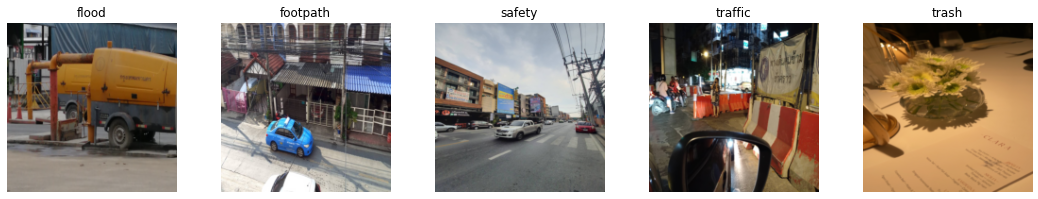

In [6]:
# use np.unique to get all unique values in the list of labels
labels = np.unique(data['label'])
 
# set up the matplotlib figure and axes, based on the number of labels
fig, axes = plt.subplots(1, len(labels))
fig.set_size_inches(15,4)
fig.tight_layout()
 
# make a plot for every label (equipment) type. The index method returns the 
# index of the first item corresponding to its search string, label in this case
for ax, label in zip(axes, labels):
    idx = data['label'].index(label)
     
    ax.imshow(data['data'][idx])
    ax.axis('off')
    ax.set_title(label)

แบ่งข้อมูลออกเป็น Train Set และ Test Set สำหรับใช้สอนและทดสอบโมเดล

In [7]:
X = np.array(data['data'])
y = np.array(data['label'])

In [8]:
from sklearn.model_selection import train_test_split
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

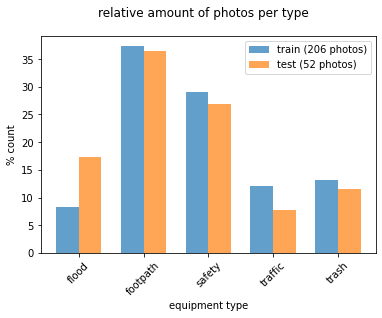

In [9]:
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
     
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
     
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
         
    xtemp = np.arange(len(unique))
     
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique, rotation=45)
    plt.xlabel('equipment type')
    plt.ylabel(ylabel_text)
 
plt.suptitle('relative amount of photos per type')
plot_bar(y_train, loc='left')
plot_bar(y_test, loc='right')
plt.legend([
    'train ({0} photos)'.format(len(y_train)), 
    'test ({0} photos)'.format(len(y_test))
]);

# Transform ข้อมูลรูปภาพ

แปลงข้อมูลรูปภาพโดยใช้ Histogram of Oriented Gradients (HOG) เพื่อทำ Feature Reduction <br>
หรือก็คือการลดความซับซ้อนของข้อมูลโดยยังคงรักษาคุณลักษณะสำคัญไว้ให้ได้มากที่สุด และการจะทำ HOG นั้น <br>
จำเป็นจะต้องแปลงรูปภาพเป็น Grayscale ก่อน

In [10]:
from skimage.feature import hog
from skimage.io import imread
from skimage.transform import rescale

In [11]:
from sklearn.base import BaseEstimator, TransformerMixin
 
class RGB2GrayTransformer(BaseEstimator, TransformerMixin):
    """
    Convert an array of RGB images to grayscale
    """
 
    def __init__(self):
        pass
 
    def fit(self, X, y=None):
        """returns itself"""
        return self
 
    def transform(self, X, y=None):
        """perform the transformation and return an array"""
        return np.array([skimage.color.rgb2gray(img) for img in X])
     
 
class HogTransformer(BaseEstimator, TransformerMixin):
    """
    Expects an array of 2d arrays (1 channel images)
    Calculates hog features for each img
    """
 
    def __init__(self, y=None, orientations=9,
                 pixels_per_cell=(8, 8),
                 cells_per_block=(3, 3), block_norm='L2-Hys'):
        self.y = y
        self.orientations = orientations
        self.pixels_per_cell = pixels_per_cell
        self.cells_per_block = cells_per_block
        self.block_norm = block_norm
 
    def fit(self, X, y=None):
        return self
 
    def transform(self, X, y=None):
 
        def local_hog(X):
            return hog(X,
                       orientations=self.orientations,
                       pixels_per_cell=self.pixels_per_cell,
                       cells_per_block=self.cells_per_block,
                       block_norm=self.block_norm)
 
        try: # parallel
            return np.array([local_hog(img) for img in X])
        except:
            return np.array([local_hog(img) for img in X])

แปลงข้อมูล X_train และ X_Test

In [12]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import StandardScaler, Normalizer
import skimage
 
# create an instance of each transformer
grayify = RGB2GrayTransformer()
hogify = HogTransformer(
    pixels_per_cell=(14, 14), 
    cells_per_block=(2,2), 
    orientations=9, 
    block_norm='L2-Hys'
)
scalify = StandardScaler()
 
# call fit_transform on each transform converting X_train step by step
X_train_gray = grayify.fit_transform(X_train)
X_train_hog = hogify.fit_transform(X_train_gray)
X_train_prepared = scalify.fit_transform(X_train_hog)
 
print(X_train_prepared.shape)

(206, 4356)


In [13]:
X_test_gray = grayify.transform(X_test)
X_test_hog = hogify.transform(X_test_gray)
X_test_prepared = scalify.transform(X_test_hog)

# SGDClassifier Model

In [14]:
sgd_clf = SGDClassifier(random_state=42, max_iter=1000, tol=1e-3)
sgd_clf.fit(X_train_prepared, y_train)

SGDClassifier(random_state=42)

# Testing and Evaluation

In [15]:
y_pred = sgd_clf.predict(X_test_prepared)
print('Percentage correct: ', 100*np.sum(y_pred == y_test)/len(y_test))

Percentage correct:  34.61538461538461


In [16]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, classification_report, confusion_matrix

In [17]:
sgd_report = classification_report(y_test, y_pred, target_names=np.unique(y_test), zero_division=False)
print(sgd_report)

              precision    recall  f1-score   support

       flood       0.33      0.11      0.17         9
    footpath       0.55      0.58      0.56        19
      safety       0.38      0.21      0.27        14
     traffic       0.10      0.25      0.14         4
       trash       0.18      0.33      0.24         6

    accuracy                           0.35        52
   macro avg       0.31      0.30      0.28        52
weighted avg       0.39      0.35      0.35        52



In [18]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix: Gaussian NB',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

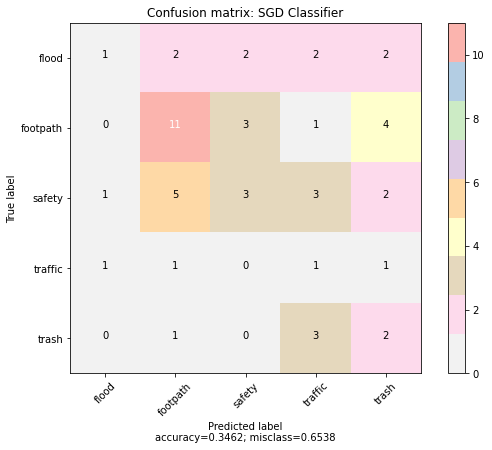

In [19]:
cm = confusion_matrix(y_test, y_pred, labels=np.unique(data['label']))
target_names = np.unique(data['label']).tolist()
plot_confusion_matrix(cm, target_names, title='Confusion matrix: SGD Classifier', cmap='Pastel1_r', normalize=False)